## 🌸BlossomBot: A Flower-Based Classifier

#### It is an advanced machine learning application designed to accurately identify and classify various types of flowers. Leveraging state-of-the-art ML algorithms and trained on the renowned Iris dataset, BlossomBot is your go-to tool for precise flower recognition.

In [84]:
# Importing Libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set(style="darkgrid")
%matplotlib inline

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import joblib

import warnings
warnings.filterwarnings("ignore")


In [85]:
# Utility Functions
def checking_overfitting_undefitting(y_train, y_train_pred, y_test, y_test_pred):
    """
    Print whether the model is underfit, overfit or good fit.
    
    y_train = training data
    y_train_pred = predictions on training data
    y_test = testing data
    y_test_pred = predictions on testing data
    """
    training_accuracy = accuracy_score(y_train, y_train_pred)
    testing_accuracy = accuracy_score(y_test, y_test_pred)
    if training_accuracy<=0.65:
        print("Model is underfitting.") 
    elif training_accuracy>0.65 and abs(training_accuracy-testing_accuracy)>0.15:
        print("Model is overfitting.")
    else:
        print("Model is not underfitting/overfitting.")

def calculate_classification_metrics(y_true, y_pred, algorithm):
    """
    Return the classification Metrics
    
    y_true = actual values
    y_pred = predicted values
    y_pred_probability = probability values
    algorithm = algorithm name
    """
    accuracy = round(accuracy_score(y_true, y_pred), 3)
    precision = round(precision_score(y_true, y_pred, average='weighted'), 3)
    recall = round(recall_score(y_true, y_pred, average='weighted'), 3)
    f1 = round(f1_score(y_true, y_pred, average='weighted'), 3)
    print("Algorithm: ", algorithm)
    print()
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print()
    cm = confusion_matrix(y_true, y_pred)
    labels = ['Overcast', 'Clear','Foggy']
    plt.figure(figsize=(10, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    return accuracy, precision, recall, f1

---

### Data Inspection

In [86]:
# Fetching data
data = pd.read_csv("dataset.csv")
data.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [87]:
# Checking datatypes/shape of data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [88]:
# Checking Statistical Summary of data
data.describe(include='all')

,sepal_length,sepal_width,petal_length,petal_width,species
count,150.000000,150.000000,150.000000,150.000000,150
unique,NaN,NaN,NaN,NaN,3
top,NaN,NaN,NaN,NaN,Iris-setosa
freq,NaN,NaN,NaN,NaN,50
mean,5.843333,3.054000,3.758667,1.198667,NaN
std,0.828066,0.433594,1.764420,0.763161,NaN
min,4.300000,2.000000,1.000000,0.100000,NaN
25%,5.100000,2.800000,1.600000,0.300000,NaN
50%,5.800000,3.000000,4.350000,1.300000,NaN
75%,6.400000,3.300000,5.100000,1.800000,NaN


---

### Data Cleaning

In [89]:
# Checking null values
data.isnull().sum()

sepal_length    0
sepal_width     0
petal_length    0
petal_width     0
species         0
dtype: int64

In [90]:
# Checking duplicated values
data.duplicated().sum()

3

In [91]:
# Removing duplicated values
data.drop_duplicates(inplace=True)
# Again checking duplicated values
data.duplicated().sum()

0

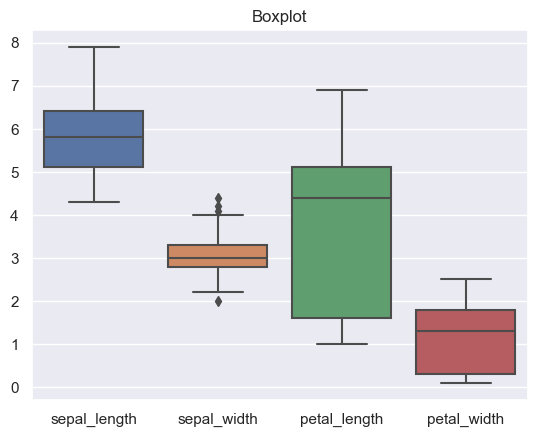

In [92]:
# Checking for outliers
sns.boxplot(data=data)
plt.title("Boxplot")
plt.show()
# Sepal_width have some outliers but we'll not remove them as they are very much close and the dataset also have few entries.

---

### Exploratory Data Analysis

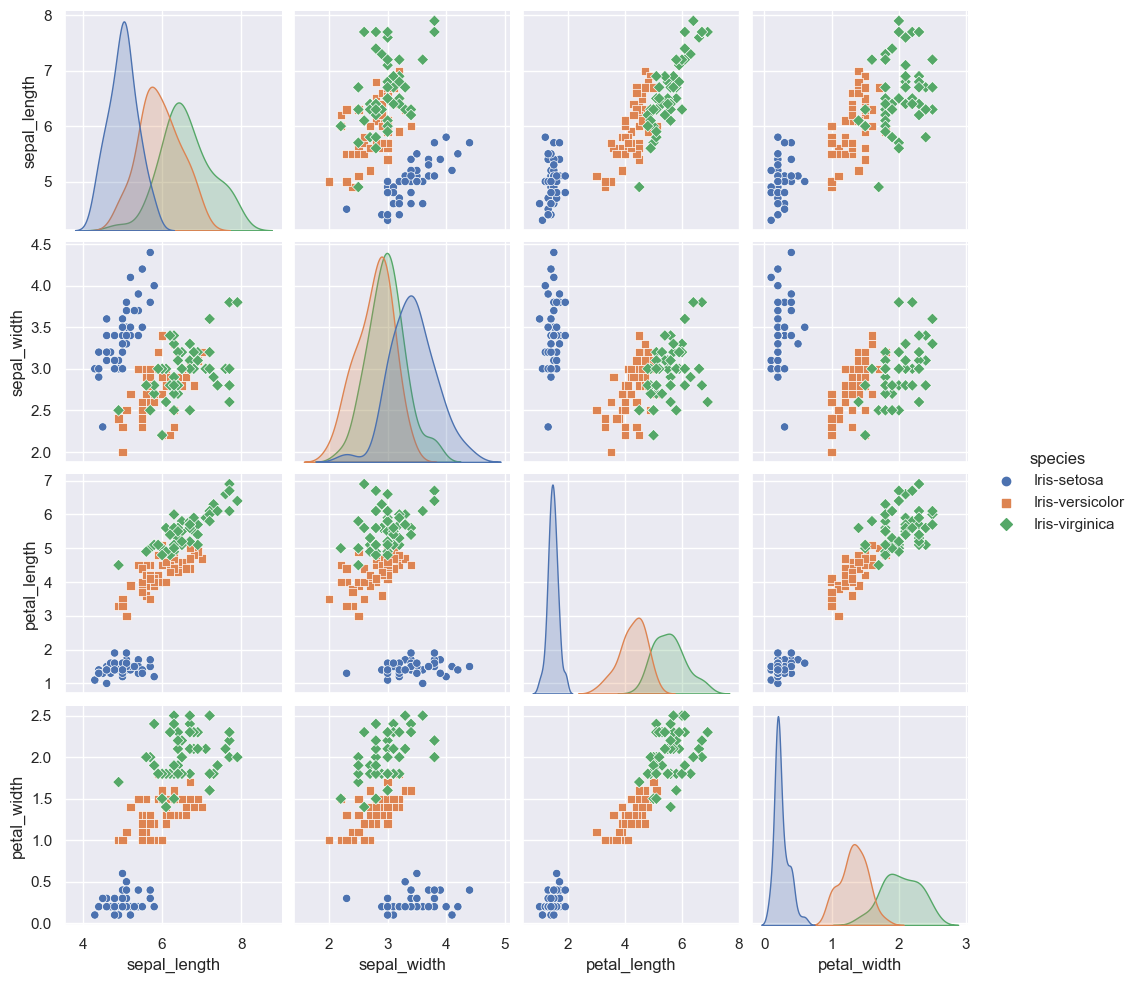

In [93]:
# Pairplot to visualize relationships between variables
sns.pairplot(data, hue="species", markers=["o", "s", "D"])

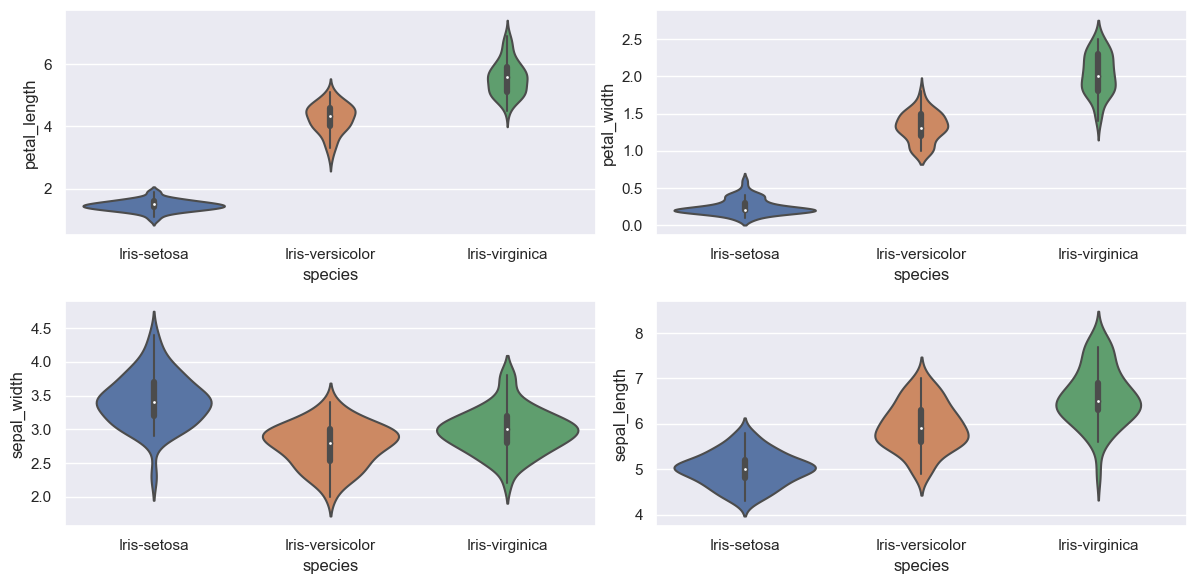

In [94]:
# Violin plot to visualize distribution and density by species
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
sns.violinplot(x="species", y="petal_length", data=data)
plt.subplot(2, 2, 2)
sns.violinplot(x="species", y="petal_width", data=data)
plt.subplot(2, 2, 3)
sns.violinplot(x="species", y="sepal_width", data=data)
plt.subplot(2, 2, 4)
sns.violinplot(x="species", y="sepal_length", data=data)
plt.tight_layout()

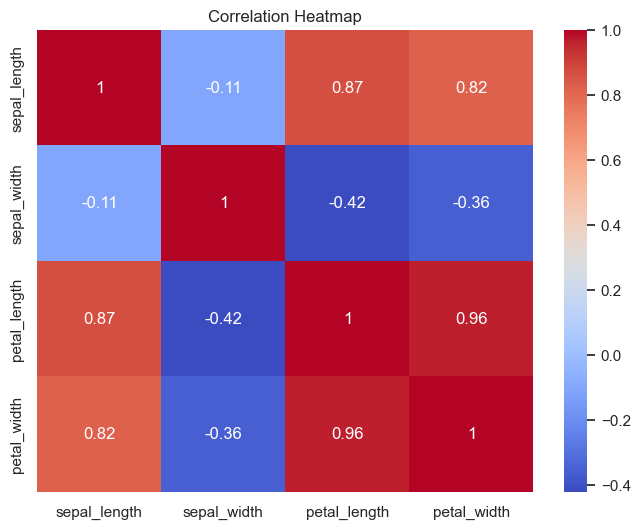

In [95]:
# Correlation heatmap
correlation = data.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

---

### Data Split & Feature Engineering

In [96]:
# Input features dataset
input_df = data.drop(columns="species", axis=1).values

In [97]:
# Target variable 
# Applying mapping
encoder = LabelEncoder()
y = data["species"]
y = encoder.fit_transform(y)

# Checking the mapping of the classes
class_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
for class_label, class_number in class_mapping.items():
    print(f"Class '{class_label}' is labeled as {class_number}")

Class 'Iris-setosa' is labeled as 0
Class 'Iris-versicolor' is labeled as 1
Class 'Iris-virginica' is labeled as 2


In [98]:
# Splitting the data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(input_df, y, test_size=0.20, random_state=42)

In [99]:
# Apply scaling on the input_df DataFrame
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']

---

### Model Building & Training


* #### Logistic Regression

In [100]:
# Hyperparameter tuning
parameters = {'solver': ['liblinear', 'saga'], 
              'multi_class':['ovr', 'multinomial'],
              'C':[0.001, 0.01, 10.0],
              'penalty': ['l1', 'l2']}
# Model Creation and Training
model_lr = LogisticRegression(n_jobs=-1)
models_lr = GridSearchCV(estimator=model_lr, param_grid=parameters, cv=4)
models_lr.fit(x_train, y_train)
best_parameters = models_lr.best_params_
print("Best Hyperparameters:", best_parameters)
print()
# Predictions for train
best_model_lr = models_lr.best_estimator_
y_pred_lr = best_model_lr.predict(x_train)
# Predictions for test
y_pred_lr_new = best_model_lr.predict(x_test)
checking_overfitting_undefitting(y_train, y_pred_lr, y_test, y_pred_lr_new)

Best Hyperparameters: {'C': 10.0, 'multi_class': 'multinomial', 'penalty': 'l1', 'solver': 'saga'}

Model is not underfitting/overfitting.


Testing Performance
Algorithm:  Logistic Regression

Accuracy: 0.967
Precision: 0.97
Recall: 0.967
F1 Score: 0.967



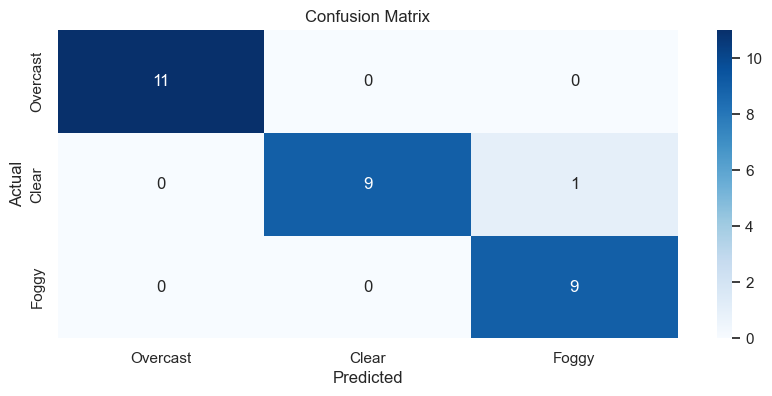

In [101]:
# Evaluation Metrics Calculation
print("Testing Performance")
accuracy_lr, precision_lr, recall_lr, f1_lr = calculate_classification_metrics(y_test, y_pred_lr_new, "Logistic Regression")

---
* #### Decision Tree

In [102]:
# Hyperparameter tuning
parameters = {'criterion':['gini', 'entropy', 'log_loss'], 
              'max_depth': [None, 5, 10],
              'min_samples_split': [None, 2, 5],
              'splitter':['best','random']}
# Model Creation and Training
model_dt = DecisionTreeClassifier()
models_dt = GridSearchCV(estimator=model_dt, param_grid=parameters, cv=4)
models_dt.fit(x_train, y_train)
best_parameters = models_dt.best_params_
print("Best Hyperparameters:", best_parameters)
print()
# Predictions on train data
best_model_dt = models_dt.best_estimator_
y_pred_dt = best_model_dt.predict(x_train)
# Predictions on test data
y_pred_dt_new = best_model_dt.predict(x_test)
checking_overfitting_undefitting(y_train, y_pred_dt, y_test, y_pred_dt_new)

Best Hyperparameters: {'criterion': 'log_loss', 'max_depth': None, 'min_samples_split': 5, 'splitter': 'random'}

Model is not underfitting/overfitting.


Testing Performance
Algorithm:  Decision Tree

Accuracy: 0.9
Precision: 0.899
Recall: 0.9
F1 Score: 0.898



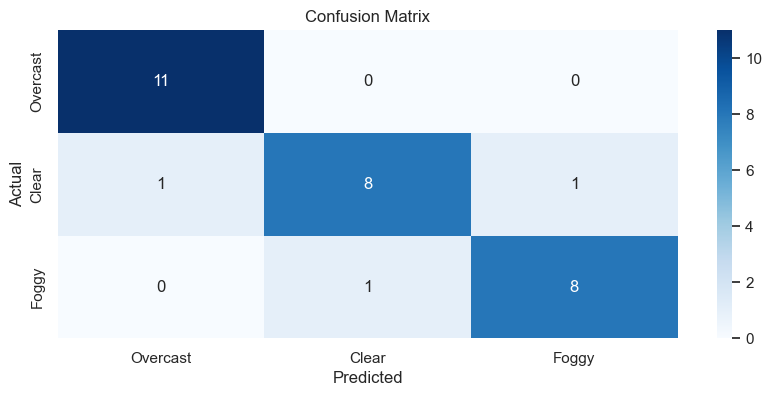

In [103]:
# Evaluation Metrics Calculation
print("Testing Performance")
accuracy_dt, precision_dt, recall_dt, f1_dt = calculate_classification_metrics(y_test, y_pred_dt_new, "Decision Tree")

---
* #### Extra Trees 

In [104]:
# Hyperparameter tuning
parameters = {'max_depth': [None, 5],
            'class_weight': [None, 'balanced'],
            'min_samples_split': [None, 2, 5],
            'criterion':['gini','log_loss','entropy']}
# Model Creation and Training
model_et = ExtraTreesClassifier()
models_et = GridSearchCV(estimator=model_et, param_grid=parameters, cv=4)
models_et.fit(x_train, y_train)
best_parameters = models_et.best_params_
print("Best Hyperparameters:", best_parameters)
print()
# Predictions on train data
best_model_et = models_et.best_estimator_
y_pred_et = best_model_et.predict(x_train)
# Predictions on test data
y_pred_et_new = best_model_et.predict(x_test)
checking_overfitting_undefitting(y_train, y_pred_et, y_test, y_pred_et_new)

Best Hyperparameters: {'class_weight': None, 'criterion': 'log_loss', 'max_depth': 5, 'min_samples_split': 2}

Model is not underfitting/overfitting.


Testing Performance
Algorithm:  Extra Trees

Accuracy: 0.933
Precision: 0.933
Recall: 0.933
F1 Score: 0.933



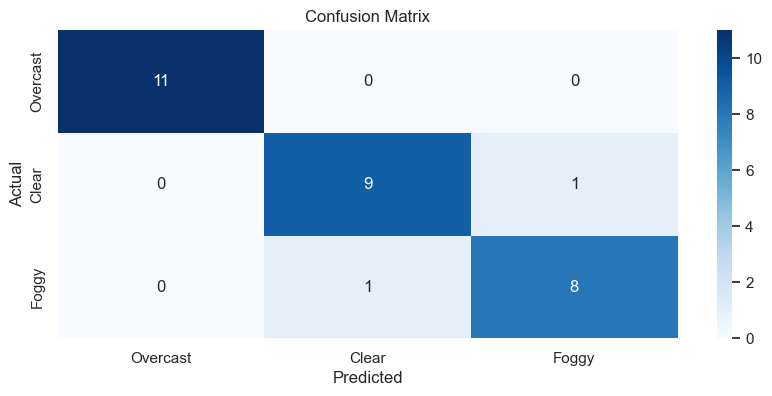

In [105]:
# Evaluation Metrics Calculation
print("Testing Performance")
accuracy_et, precision_et, recall_et, f1_et = calculate_classification_metrics(y_test, y_pred_et_new, "Extra Trees")

---
* #### Naive Bayes

In [106]:
# Hyperparameter tuning
parameters = {'var_smoothing':[1e-9, 1e-8, 1e-10]}
# Model Creation and Training
model_nb = GaussianNB()
models_nb = GridSearchCV(estimator=model_nb, param_grid=parameters, cv=4)
models_nb.fit(x_train, y_train)
best_parameters = models_nb.best_params_
print("Best Hyperparameters:", best_parameters)
print()
# Predictions on training data
best_model_nb = models_nb.best_estimator_
y_pred_nb = best_model_nb.predict(x_train)
# Predictions on test data
y_pred_nb_new = best_model_nb.predict(x_test)
checking_overfitting_undefitting(y_train, y_pred_nb, y_test, y_pred_nb_new)

Best Hyperparameters: {'var_smoothing': 1e-09}

Model is not underfitting/overfitting.


Testing Performance
Algorithm:  Gaussian NB

Accuracy: 0.967
Precision: 0.97
Recall: 0.967
F1 Score: 0.966



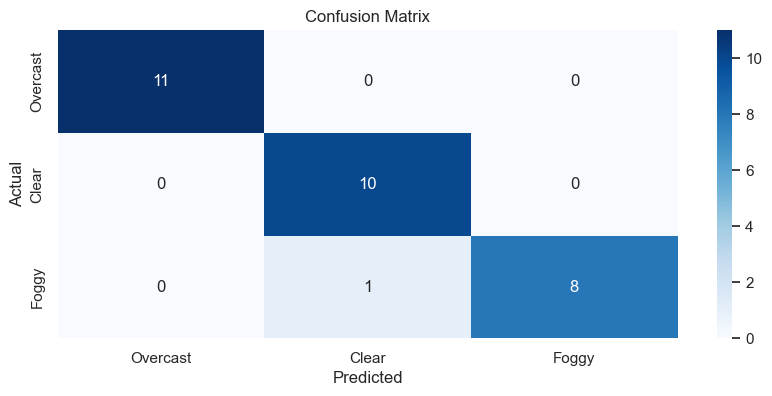

In [107]:
# Evaluation Metrics Calculation
print("Testing Performance")
accuracy_nb, precision_nb, recall_nb, f1_nb = calculate_classification_metrics(y_test, y_pred_nb_new, "Gaussian NB")

---
### Results


In [108]:
# Results
print("Testing Performances for Machine Learning Algorithms")
result = pd.DataFrame({"Algorithms":['Logistic Regression', "Decision Tree", "Extra Trees Classifier", "Gaussian Naive Bayes"],
                       "Accuracy":[accuracy_lr,  accuracy_dt, accuracy_et, accuracy_nb],
                       "Precision":[precision_lr,  precision_dt,  precision_et, precision_nb],
                       "Recall":[recall_lr,  recall_dt,  recall_et, recall_nb],
                       "F1 Score":[f1_lr,  f1_dt,  f1_et, f1_nb]}).set_index('Algorithms')
result

Testing Performances for Machine Learning Algorithms


,Accuracy,Precision,Recall,F1 Score
Algorithms,,,,
Logistic Regression,0.967,0.970,0.967,0.967
Decision Tree,0.900,0.899,0.900,0.898
Extra Trees Classifier,0.933,0.933,0.933,0.933
Gaussian Naive Bayes,0.967,0.970,0.967,0.966


---
### Model Saving

In [109]:
# Saving sklearn machine learning models
models = [best_model_dt, best_model_lr, best_model_et, best_model_nb]
names = ["dt","lr","et","nb"]
for i in range(len(models)):
    joblib.dump(models[i],names[i]+".pkl")